In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch.optim import Optimizer
from collections import OrderedDict
from sklearn import preprocessing

In [2]:
class myRprop(Optimizer):
    """Implements the resilient backpropagation algorithm. 
    For output layer, the last parameter is new parameter with learning rate L2 and other parameters have learning rate L3

    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr_new (float, optional): learning rate L2
        lr_old (float, optional): learning rate L3
        etas (Tuple[float, float], optional): pair of (etaminus, etaplis), that
            are multiplicative increase and decrease factors
            (default: (0.5, 1.2))
        step_sizes (Tuple[float, float], optional): a pair of minimal and
            maximal allowed step sizes (default: (1e-6, 50))
    """

    def __init__(self, params, lr_new=5e-3,lr_old=1e-3, etas=(0.5, 1.2), step_sizes=(1e-6, 50)):
        if not 0.0 <= lr_new:
            raise ValueError("Invalid learning rate: {}".format(lr_new))
        if not 0.0 < etas[0] < 1.0 < etas[1]:
            raise ValueError("Invalid eta values: {}, {}".format(etas[0], etas[1]))

        defaults = dict(lr_new=lr_new,lr_old=lr_old, etas=etas, step_sizes=step_sizes)
        super(myRprop, self).__init__(params, defaults)

    def step(self, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Rprop does not support sparse gradients')
                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    state['prev'] = torch.zeros_like(p.data, memory_format=torch.preserve_format)
                    #state['step_size'] = grad.new().resize_as_(grad).fill_(group['lr'])
                    #print("grad size is",grad.size())
                    if list(grad.size())[-1]==2:
                        step_size_0=grad.new().resize_as_(grad).fill_(group['lr_old'])
                    else:
                        step_size_0=grad.new().resize_as_(grad).fill_(group['lr_old'])
                        step_size_0[:,-1]=group['lr_new']
                        #print(step_size_0)
                    state['step_size']=step_size_0
                    #print("step_size 0 is ",state['step_size'])

                etaminus, etaplus = group['etas']
                step_size_min, step_size_max = group['step_sizes']
                step_size = state['step_size']

                state['step'] += 1
                # update stepsizes with step size updates with simulated annealing
                sign = grad.mul(state['prev']).sign()
                sign[sign.gt(0)] = etaplus
                sign[sign.lt(0)] = etaminus
                sign[sign.eq(0)] = 1
                
                step_size.mul_(sign).clamp_(step_size_min, step_size_max)
                
                
                # for dir<0, dfdx=0
                # for dir>=0 dfdx=dfdx
                grad = grad.clone(memory_format=torch.preserve_format)
                grad[sign.eq(etaminus)] = 0
                # update parameters
                p.data.addcmul_(-1, grad.sign(), step_size)
                state['prev'].copy_(grad)
                
        return loss

In [3]:
class mySARprop(Optimizer):
    """Implements the resilient backpropagation algorithm with simulated annealing.
    For output layer, the last parameter is new parameter with learning rate L2 and other parameters have learning rate L3

    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr_new (float, optional): learning rate L2
        lr_old (float, optional): learning rate L3
        etas (Tuple[float, float], optional): pair of (etaminus, etaplis), that
            are multiplicative increase and decrease factors
            (default: (0.5, 1.2))
        step_sizes (Tuple[float, float], optional): a pair of minimal and
            maximal allowed step sizes (default: (1e-6, 50))
        k1,k2,k3,T,r are simulated annealing parameters
        loss is the loss value from network
    """

    def __init__(self, params, lr_new=5e-3,lr_old=1e-3, etas=(0.5, 1.2), step_sizes=(1e-6, 50),k1=2,k2=2,k3=2,T=6,r=0.3,error=0.001):
        if not 0.0 <= lr_new:
            raise ValueError("Invalid learning rate: {}".format(lr_new))
        if not 0.0 < etas[0] < 1.0 < etas[1]:
            raise ValueError("Invalid eta values: {}, {}".format(etas[0], etas[1]))

        defaults = dict(lr_new=lr_new,lr_old=lr_old, etas=etas, step_sizes=step_sizes, k1=k1,k2=k2,k3=k3,T=T,r=r,error=error)
        super(mySARprop, self).__init__(params, defaults)

    def step(self, closure=None,epoch=100,error=0.5):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                k1=group['k1']
                k2=group['k2']
                k3=group['k3']
                T=group['T']
                r=group['r']
                #epoch=group['epoch']
                if k1 != 0:
                    #grad = grad.add(-p.sign()*(p**2)*k1*2**(-(T*epoch)))
                    grad = grad.add(-p*k1*2**(-(T*epoch)))
                if grad.is_sparse:
                    raise RuntimeError('Rprop does not support sparse gradients')
                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    state['prev'] = torch.zeros_like(p.data, memory_format=torch.preserve_format)
                    #state['step_size'] = grad.new().resize_as_(grad).fill_(group['lr'])
                    #print("grad size is",grad.size())
                    if list(grad.size())[-1]==2:
                        step_size_0=grad.new().resize_as_(grad).fill_(group['lr_old'])
                    else:
                        step_size_0=grad.new().resize_as_(grad).fill_(group['lr_old'])
                        step_size_0[:,-1]=group['lr_new']
                        #print(step_size_0)
                    state['step_size']=step_size_0
                    #print("step_size 0 is ",state['step_size'])

                etaminus, etaplus = group['etas']
                step_size_min, step_size_max = group['step_sizes']
                step_size = state['step_size']

                state['step'] += 1
                # update stepsizes with step size updates with simulated annealing
                sign = grad.mul(state['prev']).sign()
                sign[sign.gt(0)] = etaplus
                sign[sign.eq(0)] = 1
                sign[(sign.lt(0))& (step_size>=k2*(error**2))] = etaminus
                prev_step_size=step_size
                new_step_size=prev_step_size[(sign.lt(0))& (prev_step_size<k2*(error**2))]*etaminus+k3*r*error*2**(-T*epoch)
                step_size.mul_(sign).clamp_(step_size_min, step_size_max)
                step_size[(sign.lt(0))& (prev_step_size<k2*(error**2))]=new_step_size
                
                # for dir<0, dfdx=0
                # for dir>=0 dfdx=dfdx
                grad = grad.clone(memory_format=torch.preserve_format)
                grad[sign.eq(etaminus)] = 0
                # update parameters
                p.data.addcmul_(-1, grad.sign(), step_size)
                state['prev'].copy_(grad)
                
        return loss

In [4]:
class mySARprop2(Optimizer):
    """Implements the resilient backpropagation algorithm with simulated annealing.

    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-2)
        etas (Tuple[float, float], optional): pair of (etaminus, etaplis), that
            are multiplicative increase and decrease factors
            (default: (0.5, 1.2))
        step_sizes (Tuple[float, float], optional): a pair of minimal and
            maximal allowed step sizes (default: (1e-6, 50))
        k1,k2,k3,T,r are simulated annealing parameters
        loss is the loss value from network
    """

    def __init__(self, params, lr=1e-2, etas=(0.5, 1.2), step_sizes=(1e-6, 50),k1=2,k2=2,k3=2,T=6,r=0.3,error=0.001):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 < etas[0] < 1.0 < etas[1]:
            raise ValueError("Invalid eta values: {}, {}".format(etas[0], etas[1]))

        defaults = dict(lr=lr, etas=etas, step_sizes=step_sizes,k1=k1,k2=k2,k3=k3,T=T,r=r,error=error)
        super(mySARprop2, self).__init__(params, defaults)


    def step(self, closure=None, epoch=100,error=0.5):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad
                k1=group['k1']
                k2=group['k2']
                k3=group['k3']
                T=group['T']
                r=group['r']
                #epoch=group['epoch']
                if k1 != 0:
                    grad = grad.add(-p*k1*2**(-(T*epoch)))
                    #grad = grad.add(-p.sign()*(p**2)*k1*2**(-(T*epoch)))
                if grad.is_sparse:
                    raise RuntimeError('Rprop does not support sparse gradients')
                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    state['prev'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                    state['step_size'] = grad.new().resize_as_(grad).fill_(group['lr'])

                etaminus, etaplus = group['etas']
                step_size_min, step_size_max = group['step_sizes']
                step_size = state['step_size']

                state['step'] += 1

                sign = grad.mul(state['prev']).sign()
                # update stepsizes with step size updates with simulated annealing
                sign = grad.mul(state['prev']).sign()
                sign[sign.gt(0)] = etaplus
                sign[sign.eq(0)] = 1
                sign[(sign.lt(0))& (step_size>=k2*(error**2))] = etaminus
                prev_step_size=step_size
                new_step_size=prev_step_size[(sign.lt(0))& (prev_step_size<k2*(error**2))]*etaminus+k3*r*error*2**(-T*epoch)
                step_size.mul_(sign).clamp_(step_size_min, step_size_max)
                step_size[(sign.lt(0))& (prev_step_size<k2*(error**2))]=new_step_size

                # for dir<0, dfdx=0
                # for dir>=0 dfdx=dfdx
                grad = grad.clone(memory_format=torch.preserve_format)
                grad[sign.eq(etaminus)] = 0

                # update parameters
                #p.addcmul_(grad.sign(), step_size, value=-1)
                p.data.addcmul_(-1, grad.sign(), step_size)

                state['prev'].copy_(grad)

        return loss


In [5]:
#simple EDA 
data = pd.read_csv('Anger_data.csv')
data[['Mean','Std','Diff1','Diff2','PCAd1','PCAd2']].describe()

,Mean,Std,Diff1,Diff2,PCAd1,PCAd2
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,0.889090,0.102462,0.008421,0.209575,0.030703,0.121382
std,0.058538,0.083080,0.008153,0.097787,0.014715,0.029972
min,0.582885,0.007986,0.001081,0.021851,0.010325,0.061143
25%,0.852057,0.040081,0.002415,0.114244,0.019492,0.104173
50%,0.897453,0.068729,0.004292,0.234337,0.028206,0.117531
75%,0.934203,0.159266,0.013236,0.290046,0.035855,0.137517
max,0.983422,0.358368,0.044005,0.418234,0.083780,0.239318


In [6]:
#import data, preprocessing, scaling, seperate data into training, validation and testing balanced data
#data = pd.read_csv('Anger_data.csv')
data['Label_01']=np.where(data["Label"]=="Genuine", 0, 1)
data.drop(data.columns[[0,1,8]], axis=1, inplace=True)
x=data[['Mean','Std','Diff1','Diff2','PCAd1','PCAd2']]
y=data['Label_01']
x=pd.DataFrame(preprocessing.scale(x))
x['Label_01']=y
scaled_data=x
positive_data=scaled_data[scaled_data['Label_01']==1]
negative_data=scaled_data[scaled_data['Label_01']==0]
scaled_data.to_csv("scaled_Anger_data.csv")

msk=np.random.rand(len(positive_data))
msk_train = msk < 0.7
msk_validation = (msk >= 0.7) & (msk < 0.85)
msk_test = msk >= 0.85

train_positive_data = positive_data[msk_train]
validation_positive_data = positive_data[msk_validation]
test_positive_data = positive_data[msk_test]

train_negative_data = negative_data[msk_train]
validation_negative_data = negative_data[msk_validation]
test_negative_data = negative_data[msk_test]

train_data=pd.concat([train_positive_data,train_negative_data])
validation_data=pd.concat([validation_positive_data,validation_negative_data])
test_data=pd.concat([test_positive_data,test_negative_data])

n_features = train_data.shape[1] - 1

train_input = train_data.iloc[:, :n_features]
train_target = train_data.iloc[:, n_features]

validation_input = validation_data.iloc[:, :n_features]
validation_target = validation_data.iloc[:, n_features]

test_input = test_data.iloc[:, :n_features]
test_target = test_data.iloc[:, n_features]

X_train = torch.Tensor(train_input.values).float()
Y_train = torch.Tensor(train_target.values).long()

X_validation = torch.Tensor(validation_input.values).float()
Y_validation = torch.Tensor(validation_target.values).long()

X_test = torch.Tensor(test_input.values).float()
Y_test = torch.Tensor(test_target.values).long()

x_train = Variable(X_train)
y_train = Variable(Y_train)
x_validation = Variable(X_validation)
y_validation = Variable(Y_validation)
x_test = Variable(X_test)
y_test = Variable(Y_test)

In [11]:
#check range after scaling and data size
print(x[0].max()-x[0].min())
print(x[1].max()-x[1].min())
print(x[2].max()-x[2].min())
print(x[3].max()-x[3].min())
print(x[4].max()-x[4].min())
print(x[5].max()-x[5].min())

print("training data size is ",x_train.size()[0])
print("validation data size is ",x_validation.size()[0])
print("testing data size is ",x_test.size()[0])


6.850856531931903
4.222668920630051
5.271436501658022
4.058602406679734
4.998158182103499
5.952132429751643
training data size is  298
validation data size is  46
testing data size is  56


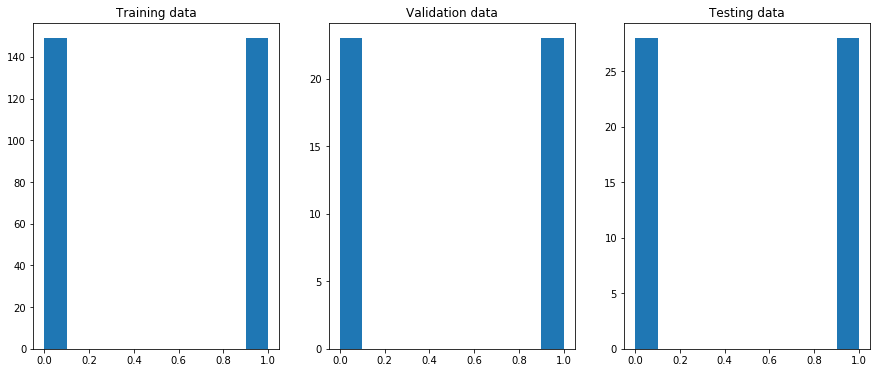

In [12]:
fig=plt.figure(figsize=(15, 6))
ax1=fig.add_subplot(1,3,1)        
ax1.hist(y_train)
ax1.set_title("Training data")

ax2=fig.add_subplot(1,3,2)        
ax2.hist(y_validation)
ax2.set_title("Validation data")

ax3=fig.add_subplot(1,3,3)        
ax3.hist(y_test)
ax3.set_title("Testing data")
plt.show()

In [13]:
num_input=6
num_output=2
num_epoch=100

act_func=nn.Sigmoid()
#act_func=F.relu()
loss_func = torch.nn.CrossEntropyLoss()
#loss_func = torch.nn.MSELoss()

In [14]:
def CasperNet(x):
    current_input=x
    current_output_list=[]
    for l in list_model:
        #print(l)
        current_h_input=l(current_input)
        current_h_output=act_func(current_h_input)
        #current_h_output=F.relu(current_h_input)
        current_input=torch.cat((current_input, current_h_output), 1)

    output_z=output_linear(current_input)
    output = F.softmax(output_z,dim=1)
    return output

In [15]:
#select learning rate
L3_list=[0.0001,0.001,0.003,0.01,0.03,0.1,0.3]
accuracy_lr_list=[]

for lr in L3_list:
    print("lr is ",lr)
    L3=lr
    L1=200*L3
    L2=5*L3
    accuracy_rep_list=[]
    for rep in range(0,10):
        #print("rep is ",rep)
        h21_linear = nn.Linear(num_input,1)
        output_linear = nn.Linear(7,num_output)

        list_model=[h21_linear]
        old_parameters=list(h21_linear.parameters())+list(output_linear.parameters())
        optimizer = torch.optim.Rprop(old_parameters, lr=L3, etas=(0.5, 1.2), step_sizes=(1e-06, 50))
        
        for epoch in range(num_epoch):

            Y_pred_train = CasperNet(x_train)
            loss = loss_func(Y_pred_train, y_train)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        Y_pred_validation = CasperNet(x_validation)
        base_loss = loss_func(Y_pred_validation, y_validation)
        _, predicted = torch.max(Y_pred_validation, 1)
        total = predicted.size(0)
        correct = predicted.data.numpy() == y_validation.data.numpy()
        #loss_list.append(loss.item())
        base_accuracy=sum(correct)/total
        
        last_weight=output_linear.weight.detach().clone()
        last_bias=output_linear.bias.detach().clone()
        
        best_loss_list=[]
        best_accuracy_list=[]
        for h in range(1,10):
            #print("hidden is ",h)
            current_input_size=num_input+h
            
            new_linear_1 = nn.Linear(current_input_size,1)
            list_model.append(new_linear_1)

            output_linear = nn.Linear(current_input_size+1,2)
            output_linear_weight=torch.cat((last_weight, torch.randn(2, 1)), 1)
            with torch.no_grad():
                output_linear.weight.copy_(output_linear_weight) 
                output_linear.bias.copy_(last_bias)
            old_parameters=[]
            for i in range(len(list_model)-1):
                old_parameters+=list(list_model[i].parameters())
            new_parameters=list_model[-1].parameters()


            optimizer1 = torch.optim.Rprop(old_parameters, lr=L3, etas=(0.5, 1.2), step_sizes=(1e-06, 50))
            optimizer2 = torch.optim.Rprop(new_parameters, lr=L1, etas=(0.5, 1.2), step_sizes=(1e-06, 50))
            optimizer3 = myRprop(output_linear.parameters(), lr_new=L2,lr_old=L3,etas=(0.5, 1.2), step_sizes=(1e-06, 50))
            
            for epoch in range(num_epoch):
                #print("epoch is ",epoch)
                Y_pred_train = CasperNet(x_train)
                loss = loss_func(Y_pred_train, y_train)
                optimizer1.zero_grad()
                optimizer2.zero_grad()
                optimizer3.zero_grad()
                loss.backward()
                optimizer1.step()
                optimizer2.step()
                optimizer3.step()
                
            Y_pred_validation = CasperNet(x_validation)
            loss = loss_func(Y_pred_validation, y_validation)
            _, predicted = torch.max(Y_pred_validation, 1)
            total = predicted.size(0)
            correct = predicted.data.numpy() == y_validation.data.numpy()
            #loss_list.append(loss.item())
            accuracy=sum(correct)/total
            
            best_loss_list.append(loss.item())
            best_accuracy_list.append(accuracy)
            last_weight=output_linear.weight.detach().clone()
            last_bias=output_linear.bias.detach().clone()
        accuracy_rep_list.append(best_accuracy_list)
    accuracy_lr_list.append(accuracy_rep_list)
            
    

lr is  0.0001
lr is  0.001
lr is  0.003
lr is  0.01
lr is  0.03
lr is  0.1
lr is  0.3


In [16]:
#pick up the best lr
lr_mean_hidden=[]
lr_std_hidden=[]
lr_mean_accuracy=[]
lr_std_accuracy=[]
for lr in accuracy_lr_list:
    max_hidden_list=[]
    max_accuracy_list=[]
    for rep in lr:
        max_hidden_list.append(rep.index(max(rep)))
        max_accuracy_list.append(max(rep))
    lr_mean_hidden.append(np.mean(max_hidden_list))
    lr_std_hidden.append(round(np.std(max_hidden_list),6))
    lr_mean_accuracy.append(round(np.mean(max_accuracy_list),6))
    lr_std_accuracy.append(round(np.std(max_accuracy_list),6))

for i in range(len(L3_list)):
    print([L3_list[i],lr_mean_hidden[i],lr_std_hidden[i],lr_mean_accuracy[i],lr_std_accuracy[i]])

[0.0001, 2.6, 2.374868, 0.769565, 0.041476]
[0.001, 3.4, 2.059126, 0.782609, 0.060714]
[0.003, 4.7, 2.45153, 0.752174, 0.055168]
[0.01, 3.9, 2.118962, 0.736957, 0.049046]
[0.03, 4.5, 2.156386, 0.726087, 0.056018]
[0.1, 4.4, 2.332381, 0.758696, 0.039431]
[0.3, 3.4, 2.457641, 0.719565, 0.031428]


In [17]:
#best lr is 0.003 with highest accuracy
L3=0.003
L1=200*L3
L2=5*L3
print([L1,L2,L3])

[0.6, 0.015, 0.003]


In [18]:
'''This block will run casper algorithm adn whole model process . For adding every hidden neuron, choose the one with minimum loss from 10 candidate pool.
Also, when running algorithm, you can choose adding to 10 or 20 hidden neurons at most and choose Rprop or SARprop.
Train model based on training data, selecting best hidden unit from candidate pool based on validation data, testing mmodel accuracy based on testing data.
Each whole process will run 10 times and result is the average.
'''
best_accuracy_list_lists=[]
best_loss_list_lists=[]
for rep in range(0,10):   #repeat the whole process 10 times
    print("repeat ",rep)
    #initialize the network with one hidden unit 
    h21_linear = nn.Linear(num_input,1)
    output_linear = nn.Linear(7,num_output)

    list_model=[h21_linear]
    old_parameters=list(h21_linear.parameters())+list(output_linear.parameters())
    #optimizer = torch.optim.Rprop(old_parameters, lr=0.001, etas=(0.5, 1.2), step_sizes=(1e-06, 50))
    optimizer = mySARprop2(old_parameters, lr=0.003, etas=(0.5, 1.2), step_sizes=(1e-06, 50))

    for epoch in range(num_epoch):

        Y_pred_train = CasperNet(x_train)
        loss = loss_func(Y_pred_train, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    Y_pred_test = CasperNet(x_test)
    base_loss = loss_func(Y_pred_test, y_test)
    _, predicted = torch.max(Y_pred_test, 1)
    total = predicted.size(0)
    correct = predicted.data.numpy() == y_test.data.numpy()
    base_accuracy=sum(correct)/total

    print("initial loss is ",np.around(base_loss.item(),6))
    print("initial accuracy is ",round(base_accuracy,6))


    last_weight=output_linear.weight.detach().clone()
    last_bias=output_linear.bias.detach().clone()

    best_parameter_list=[]
    best_loss_list=[]
    best_accuracy_list=[]
    best_loss_list.append(base_loss.item())
    best_accuracy_list.append(base_accuracy)
    
    
    for h in range(1,11):    #adding hidden neuron to 10 or 20
        print("hidden unit number ",h)
        current_input_size=num_input+h

        #candidate neuron number
        candidate_pool_parameter={}
        candidate_pool_loss={}
        candidate_pool_accuracy={}

        for c in range(10): #candidate pool
            new_linear_1 = nn.Linear(current_input_size,1)
            list_model.append(new_linear_1)

            output_linear = nn.Linear(current_input_size+1,2)
            output_linear_weight=torch.cat((last_weight, torch.randn(2, 1)), 1)
            with torch.no_grad():
                output_linear.weight.copy_(output_linear_weight) 
                output_linear.bias.copy_(last_bias)
            old_parameters=[]
            for i in range(len(list_model)-1):
                old_parameters+=list(list_model[i].parameters())
            new_parameters=list_model[-1].parameters()

            #using Rprop algorithm
            optimizer1 = torch.optim.Rprop(old_parameters, lr=L3, etas=(0.5, 1.2), step_sizes=(1e-06, 50))
            optimizer2 = torch.optim.Rprop(new_parameters, lr=L1, etas=(0.5, 1.2), step_sizes=(1e-06, 50))
            optimizer3 = myRprop(output_linear.parameters(), lr_new=L2,lr_old=L3,etas=(0.5, 1.2), step_sizes=(1e-06, 50))
            #using SARprop algorithm
#             optimizer1 = mySARprop2(old_parameters, lr=L3, etas=(0.5, 1.2), step_sizes=(1e-06, 50),k1=0.01,k2=0.1,k3=3,T=500,r=0.5)
#             optimizer2 = mySARprop2(new_parameters, lr=L1, etas=(0.5, 1.2), step_sizes=(1e-06, 50),k1=0.01,k2=0.1,k3=3,T=500,r=0.5)
#             optimizer3 = mySARprop(output_linear.parameters(), lr_new=L2,lr_old=L3,etas=(0.5, 1.2), step_sizes=(1e-06, 50),k1=0.01,k2=0.1,k3=3,T=500,r=0.5)
#             #using Adam algorithm optimizer
#             optimizer1 = torch.optim.Adam(old_parameters, lr=0.01)
#             optimizer2 = torch.optim.Adam(new_parameters, lr=0.2)
#             optimizer3 = myRprop(output_linear.parameters(), lr_new=0.05,lr_old=0.01,etas=(0.5, 1.2), step_sizes=(1e-06, 50))


            #train the new network
            for epoch in range(num_epoch):
                #print("epoch is ",epoch)
                Y_pred_train = CasperNet(x_train)
                loss = loss_func(Y_pred_train, y_train)
                optimizer1.zero_grad()
                optimizer2.zero_grad()
                optimizer3.zero_grad()
                loss.backward()
                #Rprop
                optimizer1.step()
                optimizer2.step()
                optimizer3.step()
                #SARprop
#                 optimizer1.step(epoch=epoch,error=loss)
#                 optimizer2.step(epoch=epoch,error=loss)        
#                 optimizer3.step(epoch=epoch,error=loss)

            Y_pred_validation = CasperNet(x_validation)
            loss = loss_func(Y_pred_validation, y_validation)
            _, predicted = torch.max(Y_pred_validation, 1)
            total = predicted.size(0)
            correct = predicted.data.numpy() == y_validation.data.numpy()
            accuracy=sum(correct)/total

            all_weights_list=[]
            all_bias_list=[]
            for i in range(len(list_model)):
                all_weights_list.append(list_model[i].weight.detach().clone())
                all_bias_list.append(list_model[i].bias.detach().clone())
            all_weights_list.append(output_linear.weight.detach().clone())
            all_bias_list.append(output_linear.bias.detach().clone())

            candidate_pool_loss[c]=loss
            candidate_pool_accuracy[c]=accuracy
            candidate_pool_parameter[c]=[all_weights_list,all_bias_list]
            if c<9:
                list_model.remove(new_linear_1)


        #choose the minmium loss and maximun accuracy from 10 candidate neurons
        min_key=min(candidate_pool_loss, key=candidate_pool_loss.get)
        #max_key=max(candidate_pool_accuracy, key=candidate_pool_accuracy.get)
        best_parameters=candidate_pool_parameter[min_key]  #select minimum loss
        #best_parameters=candidate_pool_parameter[max_key]  #select highest accuracy
        best_parameter_list.append(best_parameters)
        best_weights=best_parameters[0]
        best_bias=best_parameters[1]

        #assign the best weights and bias to model and determine the best neuron
        for i in range(len(list_model)):
            with torch.no_grad():
                list_model[i].weight.copy_(best_weights[i])
                list_model[i].bias.copy_(best_bias[i])
        with torch.no_grad():
            output_linear.weight.copy_(best_weights[-1])
            output_linear.bias.copy_(best_bias[-1])

        #using best model to predict on test data and calculate accuracy
        Y_pred_test = CasperNet(x_test)
        loss_test = loss_func(Y_pred_test, y_test)
        _, predicted = torch.max(Y_pred_test, 1)
        total = predicted.size(0)
        correct = predicted.data.numpy() == y_test.data.numpy()
        accuracy_test=sum(correct)/total

        print("-------------loss is--------------",[np.around(loss_test.item(),6),round(accuracy_test,6)])
        best_loss_list.append(loss_test.item())
        best_accuracy_list.append(accuracy_test)
        #save output weights and bias
        last_weight=output_linear.weight.detach().clone()
        last_bias=output_linear.bias.detach().clone()
    
    best_accuracy_list_lists.append(best_accuracy_list)
    best_loss_list_lists.append(best_loss_list)
    
    
    

repeat  0
initial loss is  0.581092
initial accuracy is  0.732143
hidden unit number  1
-------------loss is-------------- [0.529437, 0.785714]
hidden unit number  2
-------------loss is-------------- [0.49603, 0.821429]
hidden unit number  3
-------------loss is-------------- [0.509467, 0.803571]
hidden unit number  4
-------------loss is-------------- [0.492022, 0.821429]
hidden unit number  5
-------------loss is-------------- [0.491832, 0.821429]
hidden unit number  6
-------------loss is-------------- [0.474102, 0.839286]
hidden unit number  7
-------------loss is-------------- [0.473976, 0.839286]
hidden unit number  8
-------------loss is-------------- [0.491833, 0.821429]
hidden unit number  9
-------------loss is-------------- [0.494399, 0.821429]
hidden unit number  10
-------------loss is-------------- [0.50969, 0.803571]
repeat  1
initial loss is  0.695975
initial accuracy is  0.625
hidden unit number  1
-------------loss is-------------- [0.697625, 0.607143]
hidden unit nu

-------------loss is-------------- [0.474624, 0.839286]
hidden unit number  9
-------------loss is-------------- [0.456714, 0.857143]
hidden unit number  10
-------------loss is-------------- [0.491833, 0.821429]


In [19]:
#check the result from last block
best_hidden=[]
best_accuracy=[]
for l in best_accuracy_list_lists:
    best_hidden.append(l.index(max(l)))
    best_accuracy.append(max(l))
print(np.mean(best_hidden))
print(np.std(best_hidden))
print(np.mean(best_accuracy))
print(np.std(best_accuracy))

5.1
2.7367864366808017
0.8089285714285716
0.094844798034925


In [20]:
pd_SARprop_20_accuracy=pd.DataFrame(best_accuracy_list_lists)
pd_SARprop_20_loss=pd.DataFrame(best_loss_list_lists)
#save result to csv fro all situations
pd_SARprop_20_accuracy.to_csv("pd_SARprop_20_accuracy_sigmoid.csv")
pd_SARprop_20_loss.to_csv("pd_SARprop_20_loss_sigmoid.csv")

In [21]:
#simple neuron network
num_input=6
#num_hidden=20
num_output=2
Lr_list=[0.0001,0.001,0.003,0.01,0.03,0.1,0.3]
# xh_linear = nn.Linear(num_input,num_hidden)
# output_linear = nn.Linear(num_hidden,num_output)
#forward
def simple_nn(x):
    h_input=xh_linear(x)
    h_output=act_func(h_input)
    output_z=output_linear(h_output)
    output = F.softmax(output_z,dim=1)
    return output


accuracy_list_lr_lists=[]
for lr in Lr_list:
    print("lr is ",lr)
    rep_accuracy_list=[]
    for rep in range(10):
        #print("rep is ",rep)
        hidden_accuracy_list=[]
        for h in range(1,12): #total number of hidden units is 21 or 11
            xh_linear = nn.Linear(num_input,h)
            output_linear = nn.Linear(h,num_output)
            optimizer_nn = torch.optim.Rprop(list(xh_linear.parameters())+list(output_linear.parameters()), lr=0.001, etas=(0.5, 1.2), step_sizes=(1e-06, 50))
            #optimizer_nn = mySARprop2(list(xh_linear.parameters())+list(output_linear.parameters()), lr=0.001, etas=(0.5, 1.2), step_sizes=(1e-06, 50))

            for epoch in range(num_epoch):        
                Y_pred = simple_nn(x_train)
                loss = loss_func(Y_pred, y_train)
                optimizer_nn.zero_grad()
                loss.backward()
                optimizer_nn.step()

            Y_pred = simple_nn(x_test)
            loss = loss_func(Y_pred, y_test)
            _, predicted = torch.max(Y_pred, 1)
            total = predicted.size(0)
            correct = predicted.data.numpy() == y_test.data.numpy()
            accuracy=sum(correct)/total
            #print(round(accuracy,4))
            hidden_accuracy_list.append(accuracy)
        rep_accuracy_list.append(hidden_accuracy_list)
    accuracy_list_lr_lists.append(rep_accuracy_list)

lr is  0.0001
lr is  0.001
lr is  0.003
lr is  0.01
lr is  0.03
lr is  0.1
lr is  0.3


In [22]:
#select the best learning rate for simple NN
lr_mean_hidden=[]
lr_std_hidden=[]
lr_mean_accuracy=[]
lr_std_accuracy=[]
for lr in accuracy_list_lr_lists:
    max_hidden_list=[]
    max_accuracy_list=[]
    for rep in lr:
        max_hidden_list.append(rep.index(max(rep)))
        max_accuracy_list.append(max(rep))
    lr_mean_hidden.append(np.mean(max_hidden_list))
    lr_std_hidden.append(round(np.std(max_hidden_list),6))
    lr_mean_accuracy.append(round(np.mean(max_accuracy_list),6))
    lr_std_accuracy.append(round(np.std(max_accuracy_list),6))

for i in range(len(Lr_list)):
    print([Lr_list[i],lr_mean_hidden[i],lr_std_hidden[i],lr_mean_accuracy[i],lr_std_accuracy[i]])

[0.0001, 7.1, 2.662705, 0.825, 0.025]
[0.001, 7.4, 2.374868, 0.814286, 0.032143]
[0.003, 8.1, 2.165641, 0.817857, 0.030723]
[0.01, 8.0, 2.19089, 0.842857, 0.025]
[0.03, 7.1, 2.211334, 0.817857, 0.033693]
[0.1, 8.2, 1.536229, 0.853571, 0.048445]
[0.3, 7.1, 1.868154, 0.823214, 0.023214]


In [23]:
#run whole model process on simple NN
rep_accuracy_list=[]
for rep in range(10):
    print("rep is ",rep)
    hidden_accuracy_list=[]
    for h in range(1,12): #total number of hidden units is 21 or 11
        xh_linear = nn.Linear(num_input,h)
        output_linear = nn.Linear(h,num_output)
        #optimizer_nn = torch.optim.Rprop(list(xh_linear.parameters())+list(output_linear.parameters()), lr=0.01, etas=(0.5, 1.2), step_sizes=(1e-06, 50))
        optimizer_nn = mySARprop2(list(xh_linear.parameters())+list(output_linear.parameters()), lr=0.001, etas=(0.5, 1.2), step_sizes=(1e-06, 50))

        for epoch in range(num_epoch):        
            Y_pred = simple_nn(x_train)
            loss = loss_func(Y_pred, y_train)
            optimizer_nn.zero_grad()
            loss.backward()
            optimizer_nn.step()

        Y_pred = simple_nn(x_test)
        loss = loss_func(Y_pred, y_test)
        _, predicted = torch.max(Y_pred, 1)
        total = predicted.size(0)
        correct = predicted.data.numpy() == y_test.data.numpy()
        accuracy=sum(correct)/total
        #print(round(accuracy,4))
        hidden_accuracy_list.append(accuracy)
    rep_accuracy_list.append(hidden_accuracy_list)

rep is  0
rep is  1
rep is  2
rep is  3
rep is  4
rep is  5
rep is  6
rep is  7
rep is  8
rep is  9


In [24]:
#check result 
best_hidden=[]
best_accuracy=[]
for l in rep_accuracy_list:
    best_hidden.append(l.index(max(l)))
    best_accuracy.append(max(l))
print(np.mean(best_hidden))
print(np.std(best_hidden))
print(np.mean(best_accuracy))
print(np.std(best_accuracy))

6.3
2.147091055358389
0.8339285714285714
0.021204182298281988


In [262]:
#save data to csv for all situations
pd_simpleNN_20=pd.DataFrame(rep_accuracy_list)
pd_simpleNN_20.to_csv("pd_simpleNN_SARprop_20_sigmoid.csv")

In [25]:
#analyse result of 16 different situations
pd_SARprop_10=pd.read_csv("pd_SARprop_10_accuracy_second_try.csv",index_col=0)
pd_SARprop_20=pd.read_csv("pd_SARprop_20_accuracy_second_try.csv",index_col=0)
pd_Rprop_10=pd.read_csv("pd_Rprop_10_accuracy_second_try.csv",index_col=0)
pd_Rprop_20=pd.read_csv("pd_Rprop_20_accuracy_second_try.csv",index_col=0)


best_hidden_SARprop_10=[]
best_accuracy_SARprop_10=[]
for l in range(len(pd_SARprop_10)):
    best_hidden_SARprop_10.append(list(pd_SARprop_10.iloc[l]).index(max(list(pd_SARprop_10.iloc[l]))))
    best_accuracy_SARprop_10.append(max(list(pd_SARprop_10.iloc[l])))
print("---------SARprop_10_Relu-----------")
print("average number of best hidden",np.mean(best_hidden_SARprop_10))
print("median number of best hidden",np.median(best_hidden_SARprop_10))
print("std of number of best hidden",np.std(best_hidden_SARprop_10))
print("average best accuracy",np.mean(best_accuracy_SARprop_10))
print("median best accuracy",np.median(best_accuracy_SARprop_10))
print("std of average best accuracy",np.std(best_accuracy_SARprop_10))

best_hidden_SARprop_20=[]
best_accuracy_SARprop_20=[]
for l in range(len(pd_SARprop_20)):
    best_hidden_SARprop_20.append(list(pd_SARprop_20.iloc[l]).index(max(list(pd_SARprop_20.iloc[l]))))
    best_accuracy_SARprop_20.append(max(list(pd_SARprop_20.iloc[l])))
print("---------SARprop_20_Relu-----------")
print("average number of best hidden",np.mean(best_hidden_SARprop_20))
print("median number of best hidden",np.median(best_hidden_SARprop_20))
print("std of number of best hidden",np.std(best_hidden_SARprop_20))
print("average best accuracy",np.mean(best_accuracy_SARprop_20))
print("median best accuracy",np.median(best_accuracy_SARprop_20))
print("std of average best accuracy",np.std(best_accuracy_SARprop_20))

best_hidden_Rprop_10=[]
best_accuracy_Rprop_10=[]
for l in range(len(pd_Rprop_10)):
    best_hidden_Rprop_10.append(list(pd_Rprop_10.iloc[l]).index(max(list(pd_Rprop_10.iloc[l]))))
    best_accuracy_Rprop_10.append(max(list(pd_Rprop_10.iloc[l])))
print("---------Rprop_10_Relu-----------")
print("average number of best hidden",np.mean(best_hidden_Rprop_10))
print("median number of best hidden",np.median(best_hidden_Rprop_10))
print("std of number of best hidden",np.std(best_hidden_Rprop_10))
print("average best accuracy",np.mean(best_accuracy_Rprop_10))
print("median best accuracy",np.median(best_accuracy_Rprop_10))
print("std of average best accuracy",np.std(best_accuracy_Rprop_10))

best_hidden_Rprop_20=[]
best_accuracy_Rprop_20=[]
for l in range(len(pd_Rprop_20)):
    best_hidden_Rprop_20.append(list(pd_Rprop_20.iloc[l]).index(max(list(pd_Rprop_20.iloc[l]))))
    best_accuracy_Rprop_20.append(max(list(pd_Rprop_20.iloc[l])))
print("---------Rprop_20_Relu-----------")
print("average number of best hidden",np.mean(best_hidden_Rprop_20))
print("median number of best hidden",np.median(best_hidden_Rprop_20))
print("std of number of best hidden",np.std(best_hidden_Rprop_20))
print("average best accuracy",np.mean(best_accuracy_Rprop_20))
print("median best accuracy",np.median(best_accuracy_Rprop_20))
print("std of average best accuracy",np.std(best_accuracy_Rprop_20))

pd_SARprop_10_sigmoid=pd.read_csv("pd_SARprop_10_accuracy_sigmoid.csv",index_col=0)
pd_SARprop_20_sigmoid=pd.read_csv("pd_SARprop_20_accuracy_sigmoid.csv",index_col=0)
pd_Rprop_10_sigmoid=pd.read_csv("pd_Rprop_10_accuracy_sigmoid.csv",index_col=0)
pd_Rprop_20_sigmoid=pd.read_csv("pd_Rprop_20_accuracy_sigmoid.csv",index_col=0)


best_hidden_SARprop_10_sigmoid=[]
best_accuracy_SARprop_10_sigmoid=[]
for l in range(len(pd_SARprop_10_sigmoid)):
    best_hidden_SARprop_10_sigmoid.append(list(pd_SARprop_10_sigmoid.iloc[l]).index(max(list(pd_SARprop_10_sigmoid.iloc[l]))))
    best_accuracy_SARprop_10_sigmoid.append(max(list(pd_SARprop_10_sigmoid.iloc[l])))
print("---------SARprop_10_sigmoid-----------")
print("average number of best hidden",np.mean(best_hidden_SARprop_10_sigmoid))
print("median number of best hidden",np.median(best_hidden_SARprop_10_sigmoid))
print("std of number of best hidden",np.std(best_hidden_SARprop_10_sigmoid))
print("average best accuracy",np.mean(best_accuracy_SARprop_10_sigmoid))
print("median best accuracy",np.median(best_accuracy_SARprop_10_sigmoid))
print("std of average best accuracy",np.std(best_accuracy_SARprop_10_sigmoid))

best_hidden_SARprop_20_sigmoid=[]
best_accuracy_SARprop_20_sigmoid=[]
for l in range(len(pd_SARprop_20_sigmoid)):
    best_hidden_SARprop_20_sigmoid.append(list(pd_SARprop_20_sigmoid.iloc[l]).index(max(list(pd_SARprop_20_sigmoid.iloc[l]))))
    best_accuracy_SARprop_20_sigmoid.append(max(list(pd_SARprop_20_sigmoid.iloc[l])))
print("---------SARprop_20_sigmoid-----------")
print("average number of best hidden",np.mean(best_hidden_SARprop_20_sigmoid))
print("median number of best hidden",np.median(best_hidden_SARprop_20_sigmoid))
print("std of number of best hidden",np.std(best_hidden_SARprop_20_sigmoid))
print("average best accuracy",np.mean(best_accuracy_SARprop_20_sigmoid))
print("median best accuracy",np.median(best_accuracy_SARprop_20_sigmoid))
print("std of average best accuracy",np.std(best_accuracy_SARprop_20_sigmoid))

best_hidden_Rprop_10_sigmoid=[]
best_accuracy_Rprop_10_sigmoid=[]
for l in range(len(pd_Rprop_10_sigmoid)):
    best_hidden_Rprop_10_sigmoid.append(list(pd_Rprop_10_sigmoid.iloc[l]).index(max(list(pd_Rprop_10_sigmoid.iloc[l]))))
    best_accuracy_Rprop_10_sigmoid.append(max(list(pd_Rprop_10_sigmoid.iloc[l])))
print("---------Rprop_10_sigmoid-----------")
print("average number of best hidden",np.mean(best_hidden_Rprop_10_sigmoid))
print("median number of best hidden",np.median(best_hidden_Rprop_10_sigmoid))
print("std of number of best hidden",np.std(best_hidden_Rprop_10_sigmoid))
print("average best accuracy",np.mean(best_accuracy_Rprop_10_sigmoid))
print("median best accuracy",np.median(best_accuracy_Rprop_10_sigmoid))
print("std of average best accuracy",np.std(best_accuracy_Rprop_10_sigmoid))

best_hidden_Rprop_20_sigmoid=[]
best_accuracy_Rprop_20_sigmoid=[]
for l in range(len(pd_Rprop_20_sigmoid)):
    best_hidden_Rprop_20_sigmoid.append(list(pd_Rprop_20_sigmoid.iloc[l]).index(max(list(pd_Rprop_20_sigmoid.iloc[l]))))
    best_accuracy_Rprop_20_sigmoid.append(max(list(pd_Rprop_20_sigmoid.iloc[l])))
print("---------Rprop_20_sigmoid-----------")
print("average number of best hidden",np.mean(best_hidden_Rprop_20_sigmoid))
print("median number of best hidden",np.median(best_hidden_Rprop_20_sigmoid))
print("std of number of best hidden",np.std(best_hidden_Rprop_20_sigmoid))
print("average best accuracy",np.mean(best_accuracy_Rprop_20_sigmoid))
print("median best accuracy",np.median(best_accuracy_Rprop_20_sigmoid))
print("std of average best accuracy",np.std(best_accuracy_Rprop_20_sigmoid))

pd_simpleNN_20=pd.read_csv("pd_simpleNN_20.csv",index_col=0)
pd_simpleNN_10=pd.read_csv("pd_simpleNN_10.csv",index_col=0)
pd_simpleNN_SARprop_10=pd.read_csv("pd_simpleNN_SARprop_10.csv",index_col=0)
pd_simpleNN_SARprop_20=pd.read_csv("pd_simpleNN_SARprop_20.csv",index_col=0)

best_hidden_simpleNN_20=[]
best_accuracy_simpleNN_20=[]
for l in range(len(pd_simpleNN_20)):
    best_hidden_simpleNN_20.append(list(pd_simpleNN_20.iloc[l]).index(max(list(pd_simpleNN_20.iloc[l]))))
    best_accuracy_simpleNN_20.append(max(list(pd_simpleNN_20.iloc[l])))
print("---------simpleNN_20_Relu-----------")
print("average number of best hidden",np.round(np.mean(best_hidden_simpleNN_20),6))
print("median number of best hidden",np.median(best_hidden_simpleNN_20))
print("std of number of best hidden",np.round(np.std(best_hidden_simpleNN_20),6))
print("average best accuracy",np.round(np.mean(best_accuracy_simpleNN_20),6))
print("median best accuracy",np.median(best_accuracy_simpleNN_20))
print("std of average best accuracy",np.round(np.std(best_accuracy_simpleNN_20),6))

best_hidden_simpleNN_10=[]
best_accuracy_simpleNN_10=[]
for l in range(len(pd_simpleNN_10)):
    best_hidden_simpleNN_10.append(list(pd_simpleNN_10.iloc[l]).index(max(list(pd_simpleNN_10.iloc[l]))))
    best_accuracy_simpleNN_10.append(max(list(pd_simpleNN_10.iloc[l])))
print("---------simpleNN_10_Relu-----------")
print("average number of best hidden",np.round(np.mean(best_hidden_simpleNN_10),6))
print("median number of best hidden",np.median(best_hidden_simpleNN_10))
print("std of number of best hidden",np.round(np.std(best_hidden_simpleNN_10),6))
print("average best accuracy",np.round(np.mean(best_accuracy_simpleNN_10),6))
print("median best accuracy",np.median(best_accuracy_simpleNN_10))
print("std of average best accuracy",np.round(np.std(best_accuracy_simpleNN_10),6))

best_hidden_simpleNN_SA_10=[]
best_accuracy_simpleNN_SA_10=[]
for l in range(len(pd_simpleNN_SARprop_10)):
    best_hidden_simpleNN_SA_10.append(list(pd_simpleNN_SARprop_10.iloc[l]).index(max(list(pd_simpleNN_SARprop_10.iloc[l]))))
    best_accuracy_simpleNN_SA_10.append(max(list(pd_simpleNN_SARprop_10.iloc[l])))
print("---------simpleNN_SARprop_10_Relu-----------")
print("average number of best hidden",np.round(np.mean(best_hidden_simpleNN_SA_10),6))
print("median number of best hidden",np.median(best_hidden_simpleNN_SA_10))
print("std of number of best hidden",np.round(np.std(best_hidden_simpleNN_SA_10),6))
print("average best accuracy",np.round(np.mean(best_accuracy_simpleNN_SA_10),6))
print("median best accuracy",np.median(best_accuracy_simpleNN_SA_10))
print("std of average best accuracy",np.round(np.std(best_accuracy_simpleNN_SA_10),6))

best_hidden_simpleNN_SA_20=[]
best_accuracy_simpleNN_SA_20=[]
for l in range(len(pd_simpleNN_SARprop_20)):
    best_hidden_simpleNN_SA_20.append(list(pd_simpleNN_SARprop_20.iloc[l]).index(max(list(pd_simpleNN_SARprop_20.iloc[l]))))
    best_accuracy_simpleNN_SA_20.append(max(list(pd_simpleNN_SARprop_20.iloc[l])))
print("---------simpleNN_SARprop_20_Relu-----------")
print("average number of best hidden",np.round(np.mean(best_hidden_simpleNN_SA_20),6))
print("median number of best hidden",np.median(best_hidden_simpleNN_SA_20))
print("std of number of best hidden",np.round(np.std(best_hidden_simpleNN_SA_20),6))
print("average best accuracy",np.round(np.mean(best_accuracy_simpleNN_SA_20),6))
print("median best accuracy",np.median(best_accuracy_simpleNN_SA_20))
print("std of average best accuracy",np.round(np.std(best_accuracy_simpleNN_SA_20),6))

pd_simpleNN_20_sigmoid=pd.read_csv("pd_simpleNN_Rprop_20_sigmoid.csv",index_col=0)
pd_simpleNN_10_sigmoid=pd.read_csv("pd_simpleNN_Rprop_10_sigmoid.csv",index_col=0)
pd_simpleNN_SARprop_10_sigmoid=pd.read_csv("pd_simpleNN_SARprop_10_sigmoid.csv",index_col=0)
pd_simpleNN_SARprop_20_sigmoid=pd.read_csv("pd_simpleNN_SARprop_20_sigmoid.csv",index_col=0)

best_hidden_simpleNN_20_sigmoid=[]
best_accuracy_simpleNN_20_sigmoid=[]
for l in range(len(pd_simpleNN_20_sigmoid)):
    best_hidden_simpleNN_20_sigmoid.append(list(pd_simpleNN_20_sigmoid.iloc[l]).index(max(list(pd_simpleNN_20_sigmoid.iloc[l]))))
    best_accuracy_simpleNN_20_sigmoid.append(max(list(pd_simpleNN_20_sigmoid.iloc[l])))
print("---------simpleNN_20_sigmoid-----------")
print("average number of best hidden",np.round(np.mean(best_hidden_simpleNN_20_sigmoid),6))
print("median number of best hidden",np.median(best_hidden_simpleNN_20_sigmoid))
print("std of number of best hidden",np.round(np.std(best_hidden_simpleNN_20_sigmoid),6))
print("average best accuracy",np.round(np.mean(best_accuracy_simpleNN_20_sigmoid),6))
print("median best accuracy",np.median(best_accuracy_simpleNN_20_sigmoid))
print("std of average best accuracy",np.round(np.std(best_accuracy_simpleNN_20_sigmoid),6))

best_hidden_simpleNN_10_sigmoid=[]
best_accuracy_simpleNN_10_sigmoid=[]
for l in range(len(pd_simpleNN_10_sigmoid)):
    best_hidden_simpleNN_10_sigmoid.append(list(pd_simpleNN_10_sigmoid.iloc[l]).index(max(list(pd_simpleNN_10_sigmoid.iloc[l]))))
    best_accuracy_simpleNN_10_sigmoid.append(max(list(pd_simpleNN_10_sigmoid.iloc[l])))
print("---------simpleNN_10_sigmoid-----------")
print("average number of best hidden",np.round(np.mean(best_hidden_simpleNN_10_sigmoid),6))
print("median number of best hidden",np.median(best_hidden_simpleNN_10_sigmoid))
print("std of number of best hidden",np.round(np.std(best_hidden_simpleNN_10_sigmoid),6))
print("average best accuracy",np.round(np.mean(best_accuracy_simpleNN_10_sigmoid),6))
print("median best accuracy",np.median(best_accuracy_simpleNN_10_sigmoid))
print("std of average best accuracy",np.round(np.std(best_accuracy_simpleNN_10_sigmoid),6))

best_hidden_simpleNN_SA_10_sigmoid=[]
best_accuracy_simpleNN_SA_10_sigmoid=[]
for l in range(len(pd_simpleNN_SARprop_10_sigmoid)):
    best_hidden_simpleNN_SA_10_sigmoid.append(list(pd_simpleNN_SARprop_10_sigmoid.iloc[l]).index(max(list(pd_simpleNN_SARprop_10_sigmoid.iloc[l]))))
    best_accuracy_simpleNN_SA_10_sigmoid.append(max(list(pd_simpleNN_SARprop_10_sigmoid.iloc[l])))
print("---------simpleNN_SARprop_10_sigmoid-----------")
print("average number of best hidden",np.round(np.mean(best_hidden_simpleNN_SA_10_sigmoid),6))
print("median number of best hidden",np.median(best_hidden_simpleNN_SA_10_sigmoid))
print("std of number of best hidden",np.round(np.std(best_hidden_simpleNN_SA_10_sigmoid),6))
print("average best accuracy",np.round(np.mean(best_accuracy_simpleNN_SA_10_sigmoid),6))
print("median best accuracy",np.median(best_accuracy_simpleNN_SA_10_sigmoid))
print("std of average best accuracy",np.round(np.std(best_accuracy_simpleNN_SA_10_sigmoid),6))

best_hidden_simpleNN_SA_20_sigmoid=[]
best_accuracy_simpleNN_SA_20_sigmoid=[]
for l in range(len(pd_simpleNN_SARprop_20_sigmoid)):
    best_hidden_simpleNN_SA_20_sigmoid.append(list(pd_simpleNN_SARprop_20_sigmoid.iloc[l]).index(max(list(pd_simpleNN_SARprop_20_sigmoid.iloc[l]))))
    best_accuracy_simpleNN_SA_20_sigmoid.append(max(list(pd_simpleNN_SARprop_20_sigmoid.iloc[l])))
print("---------simpleNN_SARprop_20_sigmoid-----------")
print("average number of best hidden",np.round(np.mean(best_hidden_simpleNN_SA_20_sigmoid),6))
print("median number of best hidden",np.median(best_hidden_simpleNN_SA_20_sigmoid))
print("std of number of best hidden",np.round(np.std(best_hidden_simpleNN_SA_20_sigmoid),6))
print("average best accuracy",np.round(np.mean(best_accuracy_simpleNN_SA_20_sigmoid),6))
print("median best accuracy",np.median(best_accuracy_simpleNN_SA_20_sigmoid))
print("std of average best accuracy",np.round(np.std(best_accuracy_simpleNN_SA_20_sigmoid),6))

---------SARprop_10_Relu-----------
average number of best hidden 4.7
median number of best hidden 4.5
std of number of best hidden 1.7916472867168918
average best accuracy 0.8461538461538461
median best accuracy 0.8365384615384615
std of average best accuracy 0.05160156871153365
---------SARprop_20_Relu-----------
average number of best hidden 5.9
median number of best hidden 4.0
std of number of best hidden 5.374941860150676
average best accuracy 0.8365384615384615
median best accuracy 0.8269230769230769
std of average best accuracy 0.04146895894778431
---------Rprop_10_Relu-----------
average number of best hidden 6.0
median number of best hidden 5.5
std of number of best hidden 2.04939015319192
average best accuracy 0.8596153846153847
median best accuracy 0.8653846153846154
std of average best accuracy 0.0455489203166424
---------Rprop_20_Relu-----------
average number of best hidden 5.6
median number of best hidden 5.5
std of number of best hidden 2.870540018881465
average best ac

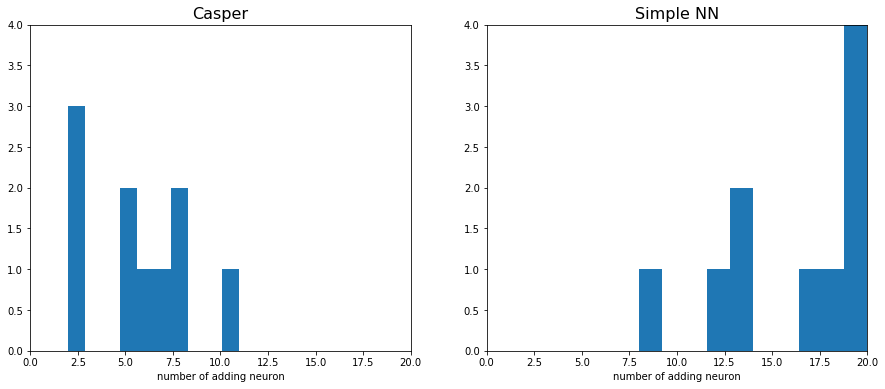

[5, 11, 2, 8, 2, 2, 6, 7, 5, 8]
[19, 13, 18, 13, 12, 17, 20, 20, 20, 8]


In [26]:
#one example from report. histogram of best hidden neurons
fig=plt.figure(figsize=(15, 6))
ax1=fig.add_subplot(1,2,1)        
ax1.hist(best_hidden_Rprop_20)
ax1.set_xlabel('number of adding neuron')
ax1.set_xlim([0,20])
ax1.set_ylim([0,4])
ax1.set_title('Casper',size=16)
#fig.suptitle('simpleNN_SARProp_10 Accuracy on test data',size=16) # or plt.suptitle('Main title')
ax2=fig.add_subplot(1,2,2)        
ax2.hist(best_hidden_simpleNN_20)
ax2.set_xlabel('number of adding neuron')
ax2.set_title('Simple NN',size=16)
ax2.set_xlim([0,20])
ax2.set_ylim([0,4])
plt.show()
print(best_hidden_Rprop_20)
print(best_hidden_simpleNN_20)

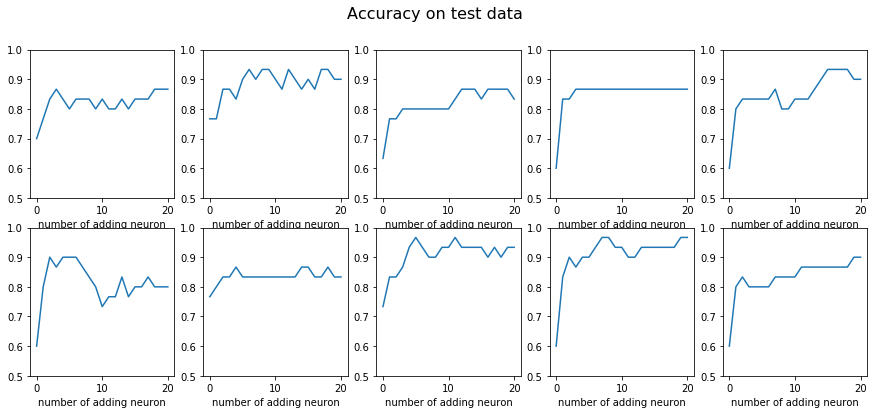

In [27]:
#one example from report.  
fig=plt.figure(figsize=(15, 6))
for i in range(1,len(pd_Rprop_20_sigmoid)+1):
    ax=fig.add_subplot(2,5,i)        
    ax.plot(list(pd_Rprop_20_sigmoid.iloc[i-1]))
    ax.set_xlabel('number of adding neuron')
    ax.set_ylim([0.5, 1])
fig.suptitle('Accuracy on test data',size=16) # or plt.suptitle('Main title')
plt.show()

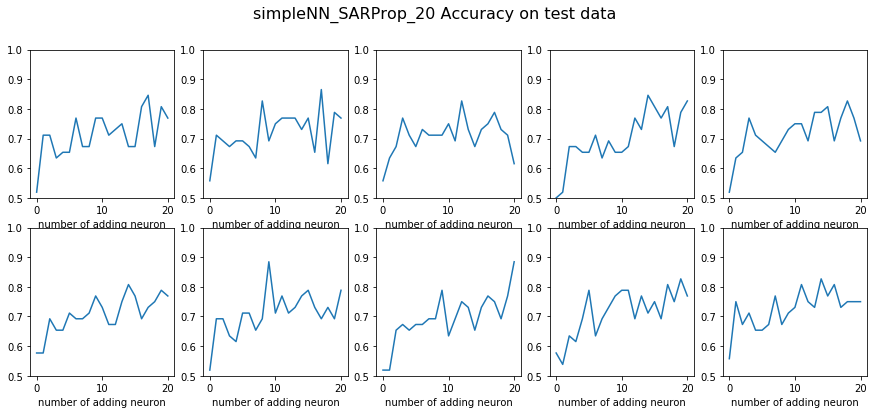

In [35]:
#This block just show the accuracy plot in different situations
# fig=plt.figure(figsize=(15, 6))
# for i in range(1,len(pd_SARprop_10)+1):
#     ax=fig.add_subplot(2,5,i)        
#     ax.plot(list(pd_SARprop_10.iloc[i-1]))
#     ax.set_xlabel('number of adding neuron')
#     ax.set_ylim([0.5, 1])
# fig.suptitle('SARprop_10 Accuracy on test data',size=16) # or plt.suptitle('Main title')
# plt.show()

# fig=plt.figure(figsize=(15, 6))
# for i in range(1,len(pd_SARprop_20)+1):
#     ax=fig.add_subplot(2,5,i)        
#     ax.plot(list(pd_SARprop_20.iloc[i-1]))
#     ax.set_xlabel('number of adding neuron')
#     ax.set_ylim([0.5, 1])
# fig.suptitle('SARprop_20 Accuracy on test data',size=16) # or plt.suptitle('Main title')
# plt.show()

# fig=plt.figure(figsize=(15, 6))
# for i in range(1,len(pd_Rprop_10)+1):
#     ax=fig.add_subplot(2,5,i)        
#     ax.plot(list(pd_Rprop_10.iloc[i-1]))
#     ax.set_xlabel('number of adding neuron')
#     ax.set_ylim([0.5, 1])
# fig.suptitle('Rprop_10 Accuracy on test data',size=16) # or plt.suptitle('Main title')
# plt.show()

# fig=plt.figure(figsize=(15, 6))
# for i in range(1,len(pd_Rprop_20)+1):
#     ax=fig.add_subplot(2,5,i)        
#     ax.plot(list(pd_Rprop_20.iloc[i-1]))
#     ax.set_xlabel('number of adding neuron')
#     ax.set_ylim([0.5, 1])
# fig.suptitle('Rprop_20 Accuracy on test data',size=16) # or plt.suptitle('Main title')
# plt.show()

# fig=plt.figure(figsize=(15, 6))
# for i in range(1,len(pd_simpleNN_20)+1):
#     ax=fig.add_subplot(2,5,i)        
#     ax.plot(list(pd_simpleNN_20.iloc[i-1]))
#     ax.set_xlabel('number of adding neuron')
#     ax.set_ylim([0.5, 1])
# fig.suptitle('simpleNN_20 Accuracy on test data',size=16) # or plt.suptitle('Main title')
# plt.show()

# fig=plt.figure(figsize=(15, 6))
# for i in range(1,len(pd_simpleNN_10)+1):
#     ax=fig.add_subplot(2,5,i)        
#     ax.plot(list(pd_simpleNN_10.iloc[i-1]))
#     ax.set_xlabel('number of adding neuron')
#     ax.set_ylim([0.5, 1])
# fig.suptitle('simpleNN_10 Accuracy on test data',size=16) # or plt.suptitle('Main title')
# plt.show()

# fig=plt.figure(figsize=(15, 6))
# for i in range(1,len(pd_simpleNN_10)+1):
#     ax=fig.add_subplot(2,5,i)        
#     ax.plot(list(pd_simpleNN_SARprop_10.iloc[i-1]))
#     ax.set_xlabel('number of adding neuron')
#     ax.set_ylim([0.5, 1])
# fig.suptitle('simpleNN_SARProp_10 Accuracy on test data',size=16) # or plt.suptitle('Main title')
# plt.show()

fig=plt.figure(figsize=(15, 6))
for i in range(1,len(pd_simpleNN_20)+1):
    ax=fig.add_subplot(2,5,i)        
    ax.plot(list(pd_simpleNN_SARprop_20.iloc[i-1]))
    ax.set_xlabel('number of adding neuron')
    ax.set_ylim([0.5, 1])
fig.suptitle('simpleNN_SARProp_20 Accuracy on test data',size=16) # or plt.suptitle('Main title')
plt.show()